In [1]:
# Import basic libraries
import os
import pandas as pd

# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# directories
current_dir = os.getcwd()
csv_folder = 'data'
acq_data_folder = 'data'

In [3]:
## reading data

# from csv's
train_csv = pd.read_csv(os.path.join(current_dir,csv_folder,'train.csv')).set_index('game_id')
test_csv = pd.read_csv(os.path.join(current_dir,csv_folder,'test.csv')).set_index('game_id')

# from scraping
scrape_csv = pd.read_csv(os.path.join(current_dir,acq_data_folder,'df_website.csv'))

# from API
api_csv = pd.read_csv(os.path.join(current_dir,acq_data_folder,'api_df_working_dist.csv'))

# from SQL
sql_csv = pd.read_csv(os.path.join(current_dir,acq_data_folder,'sql_blue_x_red_diff.csv'),sep=';')

In [4]:
# short display of data
train_csv.head(5)

,Year,Season,blueTeamTag,bResult,redTeamTag,gamelength
game_id,,,,,,
b96f782c-da04-4641-9306-68968036bfd9,2016,Summer,TT,1,HWA,50
2a7e2cb1-5ac2-4ea2-bd18-0b261e43345a,2016,Summer,CRW,0,HWA,31
e04ed84d-929b-4f0e-a769-e7bffc2b5162,2016,Summer,SUP,1,AUR,50
8829614a-313e-413c-9520-d95d7b95af31,2016,Spring,JAG,1,SSB,40
db2cf98d-a55e-4e28-9702-d7363fad2ebb,2016,Spring,SIN,0,CHF,36


In [5]:
def tidy_up_gold_df(df):
    df = df.copy()\
           .pivot(index=['game_id'], columns='Type')\
           .astype(int) 
    return df

def gold_lead_blue(df):
    # define teams
    blue_players = ['goldblueTop','goldblueJungle','goldblueMiddle','goldblueADC','goldblueSupport']
    red_players = ['goldredTop','goldredJungle','goldredMiddle','goldredADC','goldredSupport']

    # aggregate team gold
    blue_gold = df['min_10'][blue_players]\
                    .astype(int)\
                    .sum(axis=1)
    
    red_gold= df['min_10'][red_players]\
                    .astype(int)\
                    .sum(axis=1)
    
    # return team difference
    gold_lead_blue = pd.DataFrame(blue_gold-red_gold,columns=['value'])
    return gold_lead_blue

gold_lead_blue = scrape_csv.pipe(tidy_up_gold_df).pipe(gold_lead_blue)

In [6]:
gold_lead_blue

,value
game_id,
0001c4f2-b421-41e7-ae5e-6e8a61c7ad26,-1805
00032e36-8a18-472c-bf38-61b836b72e45,1815
0024055a-f824-4a82-818f-22443bd2e080,325
00265d98-0c54-4c63-935e-7367e934f06f,-1222
00281254-1bf8-42c0-9af5-9e54c6b36616,1298
...,...
ffc83dc9-b51c-4698-9963-650653ddd8e0,-3110
ffd309f7-3663-41b3-8e72-cac59c8ef3ce,-185
ffda9bac-102f-4bfd-a82f-8eb62a1af58f,-1576


In [7]:
# merge gold_diff into train_csv and test_csv
train_csv = train_csv.merge(gold_lead_blue, on='game_id', how='left')
test_csv = test_csv.merge(gold_lead_blue, on='game_id', how='left')

# merge api stuff into train_csv and test_csv
train_csv = train_csv.merge(api_csv, on='game_id', how='left').fillna(0)
test_csv = test_csv.merge(api_csv, on='game_id', how='left').fillna(0)
train_csv['Kills_diff'] = train_csv['bKills']-train_csv['rKills']
test_csv['Kills_diff'] = test_csv['bKills']-test_csv['rKills']

# merge sql stuff into train_csv and test_csv
train_csv = train_csv.merge(sql_csv, on='game_id', how='left').fillna(0)
test_csv = test_csv.merge(sql_csv, on='game_id', how='left').fillna(0)

In [8]:
train_csv.head(5)

,game_id,Year,Season,blueTeamTag,bResult,redTeamTag,gamelength,value,bKills,rKills,Kills_diff,monsters_blue,monsters_red,monsters_diff,towers_blue,towers_red,towers_diff
0,b96f782c-da04-4641-9306-68968036bfd9,2016,Summer,TT,1,HWA,50,862,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2a7e2cb1-5ac2-4ea2-bd18-0b261e43345a,2016,Summer,CRW,0,HWA,31,568,3.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0
2,e04ed84d-929b-4f0e-a769-e7bffc2b5162,2016,Summer,SUP,1,AUR,50,-56,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,8829614a-313e-413c-9520-d95d7b95af31,2016,Spring,JAG,1,SSB,40,-296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,db2cf98d-a55e-4e28-9702-d7363fad2ebb,2016,Spring,SIN,0,CHF,36,-1018,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [9]:
# train-test splitting
X = train_csv[['gamelength','value','Kills_diff','monsters_diff','towers_diff']]
y = train_csv['bResult']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [10]:
print(X_train.head(5))

   gamelength  value  Kills_diff  monsters_diff  towers_diff
0          50    862         1.0            0.0          0.0
1          31    568         3.0            1.0          0.0
2          50    -56         0.0            1.0          1.0
3          40   -296         0.0            0.0          0.0
4          36  -1018         0.0            0.0          0.0


In [96]:
# creates pipeline
pipeline = Pipeline([('rf', RandomForestClassifier(
    random_state=42,
    n_estimators=100, 
    max_features=4, 
    bootstrap=True,
    max_depth=10,
    criterion='entropy'))])

In [57]:
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([('decision tree', DecisionTreeClassifier(random_state=42, max_depth=10, criterion='gini'))])

In [23]:
# creates pipeline
pipeline = Pipeline([('log reg', LogisticRegression(random_state=42))])

In [50]:
# #inputs preprocessing

# # initialize transformer with desired options

# standardscaler = StandardScaler()
# standardscaler.fit(X_train)


# # fit transformer to data
# X_train_scale = standardscaler.transform(X_train)

# X_test_scale = standardscaler.transform(X_test)

# # store scaled version of features
# # for some reason gives a warning
# for i in range(0,X_train.shape[1]):
#     X_train.loc[:,X_train.columns[i]] = X_train_scale[:,i]
#     X_test.loc[:,X_test.columns[i]] = X_test_scale[:,i]
    
# X_train.head(5)

/home/rubelrennfix/.virtualenvs/hckt02/lib/python3.6/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,gamelength,value,Kills_diff,monsters_diff,towers_diff
0,1.574330,0.764543,0.375630,0.050235,-0.055319
1,-0.817711,0.495872,1.530921,1.412454,-0.055319
2,1.574330,-0.074369,-0.202016,1.412454,1.709465
3,0.315361,-0.293693,-0.202016,0.050235,-0.055319
4,-0.188226,-0.953491,-0.202016,0.050235,-0.055319


In [97]:
# trains model
pipeline.fit(X_train.values, y_train.values)

# predicts probabilities
y_scores = pipeline.predict_proba(X_train)[:,1]
y_scores_test = pipeline.predict_proba(X_test)[:,1]

results_df = pd.DataFrame(y_scores,columns=['bet_proba']).set_index(X_train.index)
results_df_test = pd.DataFrame(y_scores_test,columns=['bet_proba']).set_index(X_test.index)

results_df.head(5)

,bet_proba
0,0.622200
1,0.598547
2,0.560992
3,0.469995
4,0.227929


array([[<AxesSubplot:title={'center':'bet_proba'}>]], dtype=object)

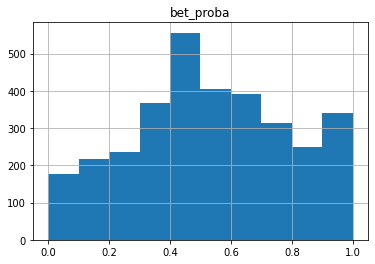

In [98]:
results_df.hist()

In [102]:
# create actual_bet column
results_df['actual_bet'] = None
results_df_test['actual_bet'] = None

# converting a probability to a bet
results_df.loc[results_df['bet_proba']>0.5,'actual_bet'] = 'WIN'
results_df.loc[results_df['bet_proba']<0.5,'actual_bet'] = 'LOSS'
results_df.loc[results_df['actual_bet'].isnull(),'actual_bet'] = 'NO BET'

results_df_test.loc[results_df_test['bet_proba']>0.8,'actual_bet'] = 'WIN'
results_df_test.loc[results_df_test['bet_proba']<0.2,'actual_bet'] = 'LOSS'
results_df_test.loc[results_df_test['actual_bet'].isnull(),'actual_bet'] = 'NO BET'

results_df.head(5)

,bet_proba,actual_bet
0,0.622200,WIN
1,0.598547,WIN
2,0.560992,WIN
3,0.469995,LOSS
4,0.227929,LOSS


In [103]:
# results assessment
win_results = y_train.loc[results_df['actual_bet'] == "WIN"]
loss_results = y_train.loc[results_df['actual_bet'] == "LOSS"]
no_bet_results = y_train.loc[results_df['actual_bet'] == "NO BET"]


a = y_train.loc[results_df['actual_bet'] == 'WIN'].values
b = y_train.loc[results_df['actual_bet'] == 'LOSS'].values

print(sum(a==1)*5 + sum(a==0)*-5 + sum(b==1)*-5 + sum(b==0)*5)

10760


In [104]:
# results assessment test
win_results = y_test.loc[results_df_test['actual_bet'] == "WIN"]
loss_results = y_test.loc[results_df_test['actual_bet'] == "LOSS"]
no_bet_results = y_test.loc[results_df_test['actual_bet'] == "NO BET"]


a = y_test.loc[results_df_test['actual_bet'] == 'WIN'].values
b = y_test.loc[results_df_test['actual_bet'] == 'LOSS'].values

print(sum(a==1)*5 + sum(a==0)*-5 + sum(b==1)*-5 + sum(b==0)*5)

850


In [69]:
# actual hackathon deliverable/output
X_final = test_csv[['gamelength','value','Kills_diff','monsters_diff','towers_diff','game_id']].set_index('game_id')

#inputs preprocessing
# initialize transformer with desired options
standardscaler = StandardScaler()
standardscaler.fit(X_final)

# fit transformer to data
X_final_scale = standardscaler.transform(X_final)

# store scaled version of features
# for some reason gives a warning
for i in range(0,X_final.shape[1]):
    X_final.loc[:,X_final.columns[i]] = X_final_scale[:,i]

# predicts probabilities
y_scores_final = pipeline.predict_proba(X_final)[:,1]

results_df_final = pd.DataFrame(y_scores_final,columns=['bet_proba']).set_index(X_final.index)

# create actual_bet column
results_df_final['bet'] = None

# converting a probability to a bet
results_df_final.loc[results_df_final['bet_proba']>0.53,'bet'] = 'WIN'
results_df_final.loc[results_df_final['bet_proba']<0.47,'bet'] = 'LOSS'
results_df_final.loc[results_df_final['bet'].isnull(),'bet'] = 'NO BET'

results_df_final = results_df_final.drop('bet_proba',axis=1)

results_df_final.head(5)

results_df_final.to_csv('bets_hck02_team12.csv')

In [70]:
print(results_df_final)

                                         bet
game_id                                     
9564c32b-dad9-4292-8efb-8fa41f026fe9  NO BET
8160b53f-417a-416c-bd66-41b115e91039  NO BET
5bd6d56b-e337-4f61-83b6-cfe21a481892  NO BET
614fd189-86c9-4f44-9b13-cf980e1ccc9f  NO BET
539f6975-88f2-40ea-8d22-4b500370e971     WIN
...                                      ...
a59e0afe-9c05-4000-9ec5-c3468f6a473b  NO BET
36ae936c-e159-49b1-96c6-3b8b877269d8  NO BET
8a2f2bb9-c899-4861-b5bb-b44e00d5a309     WIN
b6e7e76a-60e0-4494-87c6-36a036f19353  NO BET
16d6cc6f-e923-4686-a23f-d277f65d12d9    LOSS

[3552 rows x 1 columns]


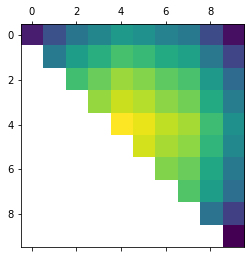

In [71]:
import numpy as np
import matplotlib.pyplot as plt
overall_results = np.ones((10,10))*np.nan
overall_results_test = np.ones((10,10))*np.nan
for row,a in enumerate(np.arange(0,1,0.1)):
    for col,b in enumerate(np.arange(0,1,0.1)):
        if a>b:
            continue
        results_df['actual_bet'] = None
        results_df.loc[results_df['bet_proba']<=a,'actual_bet'] = 'LOSS'
        results_df.loc[results_df['bet_proba']>b,'actual_bet'] = 'WIN'
        check_wins = y_train.loc[results_df['actual_bet'] == 'WIN'].values
        check_losses = y_train.loc[results_df['actual_bet'] == 'LOSS'].values
        overall_results[row,col] = sum(check_wins==1)*5 + sum(check_wins==0)*-5 + \
            sum(check_losses==0)*5 + sum(check_losses==1)*-5
        results_df_test['actual_bet'] = None
        results_df_test.loc[results_df_test['bet_proba']<=a,'actual_bet'] = 'LOSS'
        results_df_test.loc[results_df_test['bet_proba']>b,'actual_bet'] = 'WIN'
        check_wins = y_test.loc[results_df_test['actual_bet'] == 'WIN'].values
        check_losses = y_test.loc[results_df_test['actual_bet'] == 'LOSS'].values
        overall_results_test[row,col] = sum(check_wins==1)*5 + sum(check_wins==0)*-5 + \
            sum(check_losses==0)*5 + sum(check_losses==1)*-5
        
plt.matshow(overall_results_test)
plt.show()

In [79]:
X_train.rename(columns={'value':'gold_diff'}).corr()

,gamelength,gold_diff,Kills_diff,monsters_diff,towers_diff
gamelength,1.000000,-0.048695,-0.056396,-0.054000,-0.017514
gold_diff,-0.048695,1.000000,0.640512,0.176248,0.425672
Kills_diff,-0.056396,0.640512,1.000000,0.147502,0.235064
monsters_diff,-0.054000,0.176248,0.147502,1.000000,0.073703
towers_diff,-0.017514,0.425672,0.235064,0.073703,1.000000


In [81]:
import seaborn as sns

<AxesSubplot:>

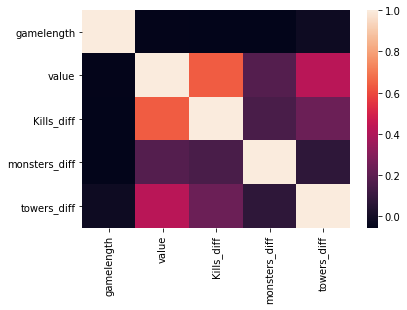

In [82]:
sns.heatmap(X_train.corr())

In [89]:
_ = train_csv[['gamelength','value','Kills_diff','monsters_diff','towers_diff','bResult']]\
            .rename(columns={'value':'gold_diff'})

<AxesSubplot:>

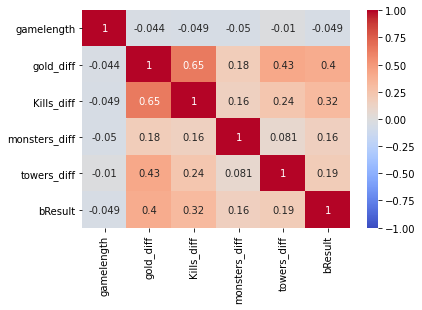

In [95]:
plt.figure()
sns.heatmap(_.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

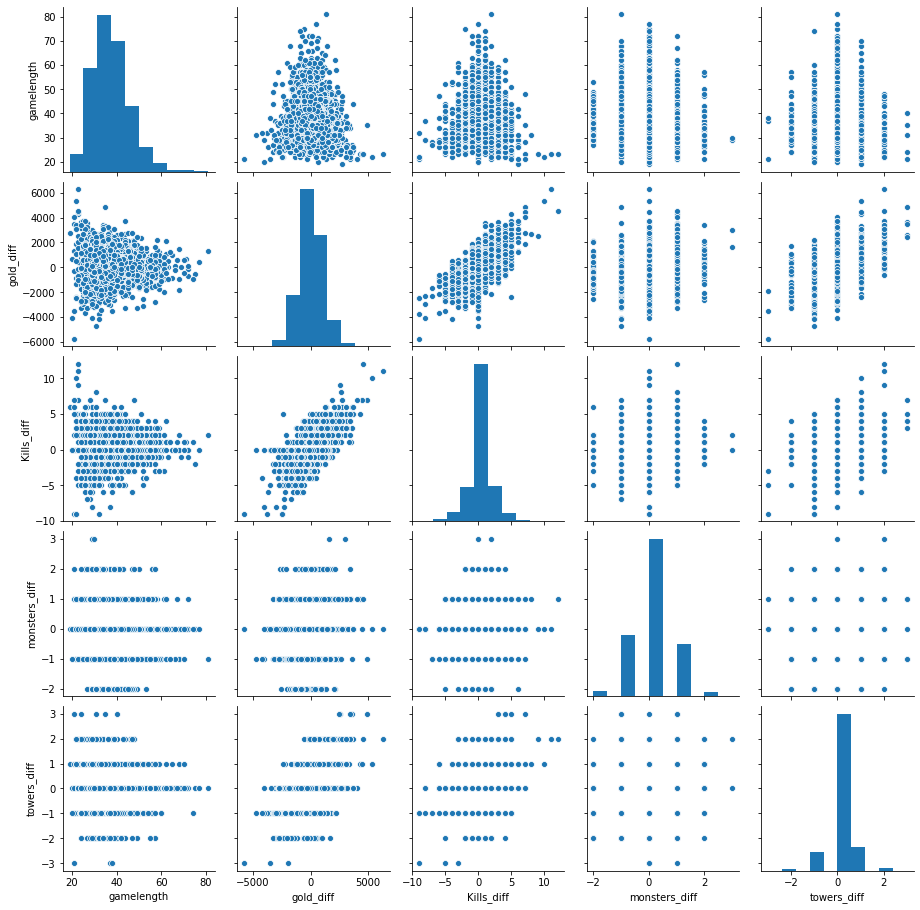

In [86]:
sns.pairplot(X_train.rename(columns={'value':'gold_diff'}))